# Use and Adaptive Shadow Ban Policy



In [1]:
#!pip install control

# Initialization

In [1]:
import numpy as np
import control.optimal as obc
import control as ct
from pyoptsparse import  Optimization, OPT
import pyoptsparse as pos
import scipy.sparse as sparse
from scipy.sparse import coo_matrix, csr_matrix, diags


import matplotlib.pyplot as plt
import scripts.shadowban_pyoptsparse as sb
from scripts.shadowban_adaptive import *
from scripts.opinion_visualization import *
import networkx as nx

import winsound
import pandas as pd
import time
import seaborn as sns
from datetime import datetime


C:\Users\trz2\Anaconda3\lib\site-packages\pyoptsparse\pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


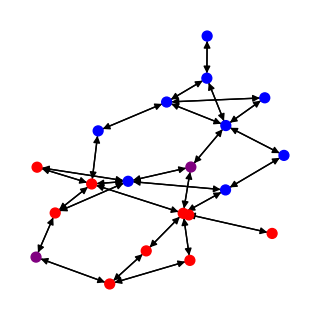

In [3]:
n0 = 20
nc = int(n0/2)
sizes = [nc, nc]
p0, p1 = 8/n0, 1/n0
probs = [[p0, p1], [p1, p0]]
G = nx.DiGraph(nx.stochastic_block_model(sizes, probs, seed=0))

for i in range(nc):
    rate = 1
    opinion0 = i/(nc-1)/2 
    opinion1 = 1-i/(nc-1)/2 
    G.nodes[i]['opinion'] = opinion0
    G.nodes[i+nc]['opinion'] = opinion1
    G.nodes[i]['rate'] = 1
    G.nodes[i+nc]['rate'] = 1
fig = draw_network(G)

## Load Network

For your network `G` you need the following node features
   1. `rates` = array of posting rate of each node
   2. `opinions0` = array of initial opinions of each node

## Set Simulation and Optimization Parameters

In [4]:
#simulation parameters
tau = 0.1
omega = 1
rates = np.array([G.nodes[v]["rate"] for v in G.nodes()])  #posting rates of nodes
opinions0 = np.array([G.nodes[v]["opinion"] for v in G.nodes()])  #initial opinions of nodes
Tf = 10     #final time of simulator
npts_eval = 100  #number of time discretization points for simulation

#optimization parameters discretization
npts = 3  #number of time discretization points for collocation
alpha = 0.0 #weight of control in cost
OBJECTIVE = 'MEAN'  #integral cost type

assert npts<npts_eval
assert OBJECTIVE in ['MEAN','VARMIN','VARMAX']

## Create params dictionary for problem

In [6]:
nv = G.number_of_nodes()
ne = G.number_of_edges()

#adjacency matrix of network
A = nx.adjacency_matrix(G)
A = A.tocoo()
E0 = nx.incidence_matrix(G,oriented=True)
E0 = E0.tocoo()
ind = E0.data>0
E = coo_matrix((E0.data[ind], (E0.row[ind], E0.col[ind])), E0.shape)  #incidence matrix with only tail of edge

ne = G.number_of_edges()
#names of edges for shadowbanning in format uij
input_names = []
for e in G.edges():
    input_names.append(f"u{e[0]}{e[1]}")
#names of nodes opinions in format thetai
output_names = []
for v in G.nodes():
    output_names.append(f"theta{v}")
    
assert nv == A.shape[0]  #number of nodes in network should equal shape of A
assert ne == E.shape[1]  #number of edges in network should equal columns of E


#parameters of network model
params = {'A':A,'E':E,'rates':rates,'tau':tau,'omega':omega, 'opinions0':opinions0,
         'npts':npts,'npts_eval':npts_eval, 'Tf':Tf,'alpha':alpha,'OBJECTIVE':OBJECTIVE}


params


{'A': <20x20 sparse array of type '<class 'numpy.intc'>'
 	with 56 stored elements in COOrdinate format>,
 'E': <20x56 sparse matrix of type '<class 'numpy.float64'>'
 	with 56 stored elements in COOrdinate format>,
 'rates': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'tau': 0.1,
 'omega': 1,
 'opinions0': array([0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
        0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ,
        1.        , 0.94444444, 0.88888889, 0.83333333, 0.77777778,
        0.72222222, 0.66666667, 0.61111111, 0.55555556, 0.5       ]),
 'npts': 3,
 'npts_eval': 100,
 'Tf': 10,
 'alpha': 0.0,
 'OBJECTIVE': 'MEAN'}

# Define Input/Output Systems

In [7]:
sys_no_agent = ct.NonlinearIOSystem(
        updfcn =sb.sys_update, outfcn= None, states=nv,
        inputs=ne, outputs = nv,
        name='shadowban network mean', params=params)

sys_mean = ct.NonlinearIOSystem(
        updfcn =sys_update_mean, outfcn= None, states=nv,
        inputs=ne, outputs = nv,
        name='shadowban network mean', params=params)

sys_varmin = ct.NonlinearIOSystem(
        updfcn =sys_update_varmin, outfcn= None, states=nv,
        inputs=ne, outputs = nv,
        name='shadowban network var min', params=params)

sys_varmax = ct.NonlinearIOSystem(
        updfcn =sys_update_varmax, outfcn= None, states=nv,
        inputs=ne, outputs = nv,
        name='shadowban network var max', params=params)

In [9]:
def plot_shadowban(T, Opinions_no_agent, Opinions_initial, Opinions_adaptive, OBJECTIVE, alpha, PLOT = True):
    Strength_adaptive = shadowban_strength(Opinions_adaptive, params)

    cost_no_agent = sb.cost_sim(OBJECTIVE, Opinions_no_agent, U = None, alpha = 0)-alpha  #need to subtract alpha because no control
    cost_linear = sb.cost_sim(OBJECTIVE, Opinions_linear, U_linear, alpha)
    cost_adaptive = sb.cost_sim(OBJECTIVE, Opinions_adaptive)-alpha*Strength_adaptive.mean()

    costs = [cost_no_agent, cost_linear, cost_adaptive] 
    
    if PLOT:
        plt.figure(figsize = (10,10))
        plt.subplot(2,2,1)
        plot_opinions(T, Opinions_no_agent)
        plt.title(f"No agent {OBJECTIVE}= {cost_no_agent:.3f}")

        plt.subplot(2,2,3)
        plot_opinions(T, Opinions_linear, U_linear)
        plt.title(f"Linear Decay Shadow Ban {OBJECTIVE} = {cost_linear:.3f}")


        plt.subplot(2,2,4)
        plot_opinions(T, Opinions_adaptive)
        plt.title(f"Adaptive Shadow Ban {OBJECTIVE} = {cost_adaptive:.3f}")
        plt.plot(T, Strength_adaptive,'.-', color = 'purple', label='Mean control')
        plt.legend()
        plt.show()
    
    return costs

## Opinions with No Shadow Banning

In [10]:
T, Opinions_no_agent, _ = sb.simulate_opinions(params, sys_no_agent)
timepts = np.linspace(0, Tf, npts, endpoint=True)
t_eval = np.linspace(0, Tf, npts_eval)

## Mean

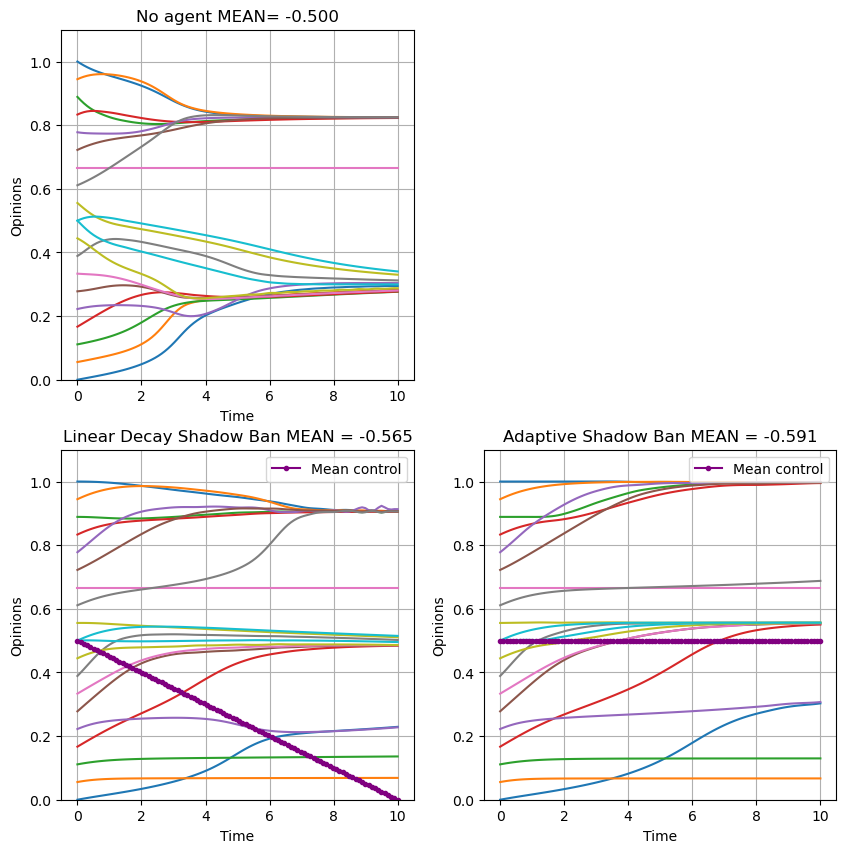

[-0.5, -0.5648185360028093, -0.5907558962173536]

In [11]:
#T, Opinions_opt, U  = sb.simulate_opinions(params, sys_mean)
OBJECTIVE = 'MEAN'
params['OBJECTIVE'] = OBJECTIVE
sys = sys_mean

#linear decay
Ucollocation_linear= sb.initial_control(params,OBJECTIVE)
T, Opinions_linear, U_linear = sb.simulate_opinions(params, sys_no_agent, Ucollocation_linear)

#adaptive shadow banning (no decay)
T, Opinions_adaptive, _ = sb.simulate_opinions(params, sys)

#####################################################
costs_mean = plot_shadowban(T, Opinions_no_agent, Opinions_linear, Opinions_adaptive, OBJECTIVE, alpha, PLOT = True)
costs_mean

## Maximize Variance

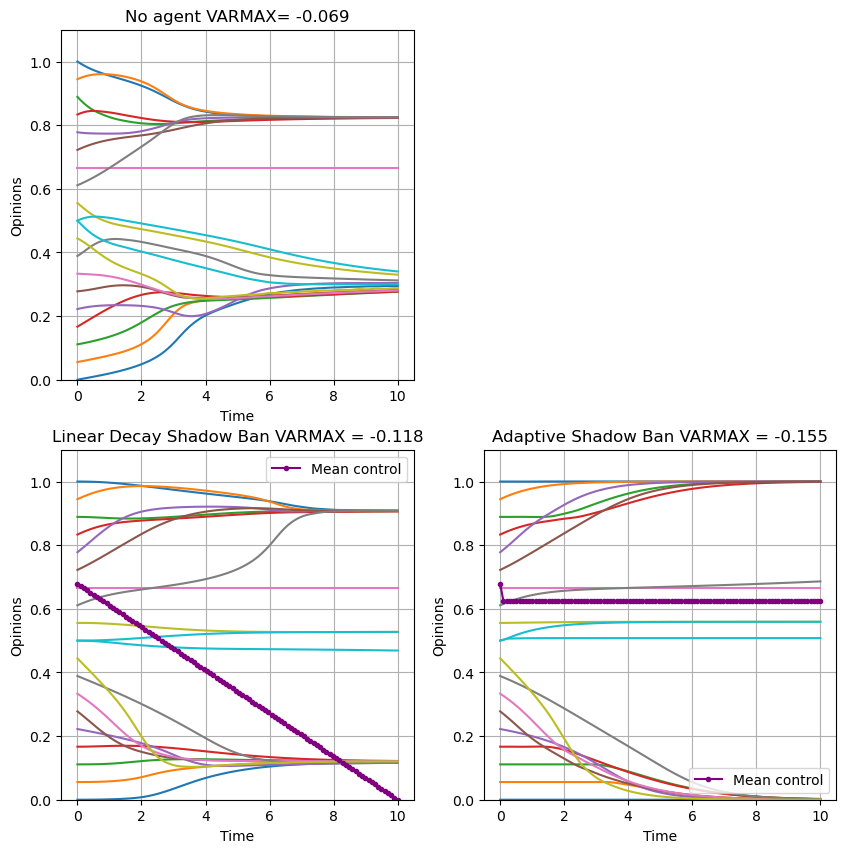

[-0.06891867281694625, -0.11781690571462733, -0.1553052410480139]

In [12]:
#T, Opinions_opt, U  = sb.simulate_opinions(params, sys_mean)
OBJECTIVE = 'VARMAX'
params['OBJECTIVE'] = OBJECTIVE
sys = sys_varmax 

#linear decay
Ucollocation_linear= sb.initial_control(params,OBJECTIVE)
T, Opinions_linear, U_linear = sb.simulate_opinions(params, sys_no_agent, Ucollocation_linear)

#adaptive shadow banning (no decay)
T, Opinions_adaptive, _ = sb.simulate_opinions(params, sys)

#####################################################
costs_varmax = plot_shadowban(T, Opinions_no_agent, Opinions_linear, Opinions_adaptive, OBJECTIVE, alpha, PLOT = True)
costs_varmax

## Minimize Variance

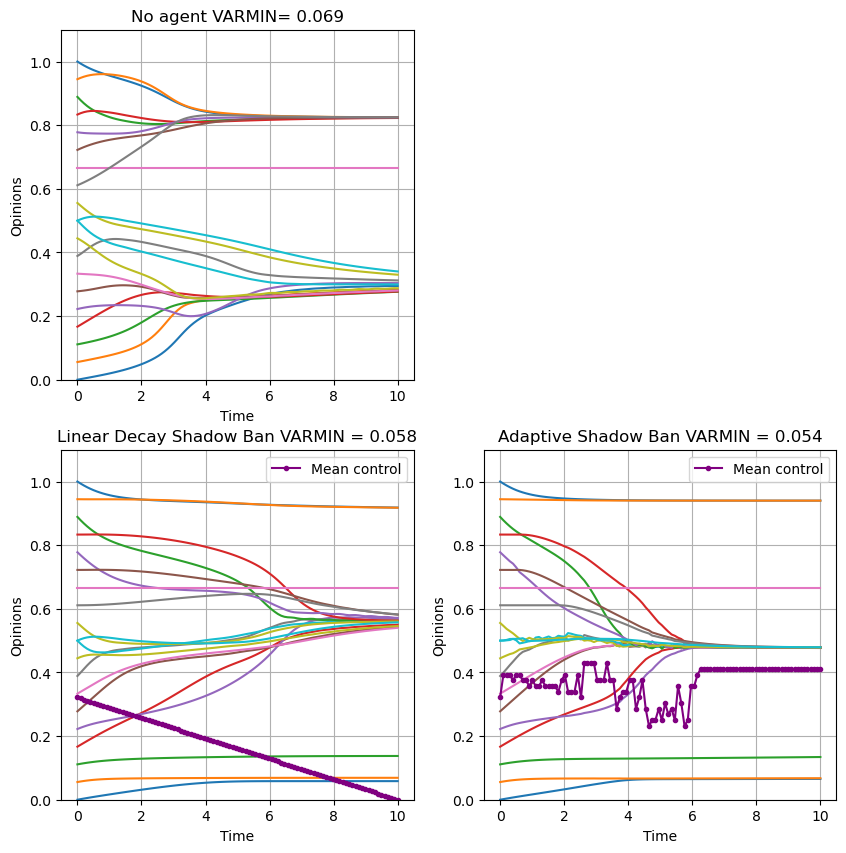

[0.06891867281694625, 0.05791024609326764, 0.054190346903666926]

In [13]:
#T, Opinions_opt, U  = sb.simulate_opinions(params, sys_mean)
OBJECTIVE = 'VARMIN'
params['OBJECTIVE'] = OBJECTIVE
sys = sys_varmin

#linear decay
Ucollocation_linear= sb.initial_control(params,OBJECTIVE)
T, Opinions_linear, U_linear = sb.simulate_opinions(params, sys_no_agent, Ucollocation_linear)

#adaptive shadow banning (no decay)
T, Opinions_adaptive, _ = sb.simulate_opinions(params, sys)

#####################################################
costs_varmax = plot_shadowban(T, Opinions_no_agent, Opinions_linear, Opinions_adaptive, OBJECTIVE, alpha, PLOT = True)
costs_varmax

# LP Solution

In [22]:
params

{'A': <20x20 sparse array of type '<class 'numpy.intc'>'
 	with 56 stored elements in COOrdinate format>,
 'E': <20x56 sparse matrix of type '<class 'numpy.float64'>'
 	with 56 stored elements in COOrdinate format>,
 'rates': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'tau': 0.1,
 'omega': 1,
 'opinions0': array([0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
        0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ,
        1.        , 0.94444444, 0.88888889, 0.83333333, 0.77777778,
        0.72222222, 0.66666667, 0.61111111, 0.55555556, 0.5       ]),
 'npts': 3,
 'npts_eval': 100,
 'Tf': 10,
 'alpha': 0.0,
 'OBJECTIVE': 'VARMIN'}

In [ ]:
OBJECTIVE = 'MEAN'
def objfunc(xdict):
    u = [xdict["u"] 
  
    funcs = {}
    funcs["cost"] = shadowban_lp(u,x,params)
    funcs["cons_shadowban_strength"] = np.sum(u)

    return funcs, False

def shadowban_lp(u,params):
    rates = params.get('rate')
    A = params.get("A")
    tau = params.get("tau")
    omega = params.get("omega")
    data = sb.shift(x[A.row]-x[A.col])
    

In [ ]:
problem = Optimization(f"{nv} node shadowban network", objfunc)   
problem.addVarGroup(f"u{k}", ne, "c", lower = 0, upper = 1, value = np.ones(ne))
problem.addConGroup(f"cons_shadowban_strength", ne, lower = None, upper = 0, wrt = [f'x{k-1}', f"x{k}",f'u{k-1}', f"u{k}"])


    #objective
    problem.addObj('cost')
    problem.printSparsity()
 